In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.nn import BCEWithLogitsLoss
from transformers import LongformerTokenizerFast, \
LongformerModel, LongformerConfig, Trainer, TrainingArguments, EvalPrediction, AutoTokenizer
from transformers.models.longformer.modeling_longformer import LongformerPreTrainedModel, LongformerClassificationHead
from torch.utils.data import Dataset, DataLoader
import random

from collections import defaultdict
from bs4 import BeautifulSoup
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
data_dir = ''
data_path = 'export.csv'

In [ ]:
df = pd.read_csv(data_path) # , nrows = 5000
df['labels'] = df['VOC_CONCEPT'].apply(lambda x: x.split('|'))
df = df[['CELEX', 'Text', 'labels']]
df.head()

,CELEX,Text,labels
0,21972A0722(03),21972A0722(03) Agreement between the European ...,"[Switzerland, trading operation, customs dutie..."
1,21980D1231(03),21980D1231(03) Decision No 3/80 of the EEC-Ice...,"[Greece, tariff policy, agreement (EU), access..."
2,21981A0710(02),21981A0710(02) Exchange of letters between the...,"[Hungary, trade agreement (EU), goatmeat, shee..."
3,21986A1115(03),15.11.1986 EN Official Journal of the European...,"[trade agreement, Portugal, protocol to an agr..."
4,21987A0720(02),20.7.1987 EN Official Journal of the European ...,"[protocol to an agreement, customs harmonisati..."


In [ ]:
print(f"There are {len(df)} rows in the dataset.")

There are 257816 rows in the dataset.


In [ ]:
total_duplicate_titles = sum(df["Text"].duplicated())
print(f"There are {total_duplicate_titles} duplicate Text.")

There are 191 duplicate Text.


In [ ]:
df = df[~df["Text"].duplicated()]
print(f"There are {len(df)} rows in the deduplicated dataset.")

There are 257625 rows in the deduplicated dataset.


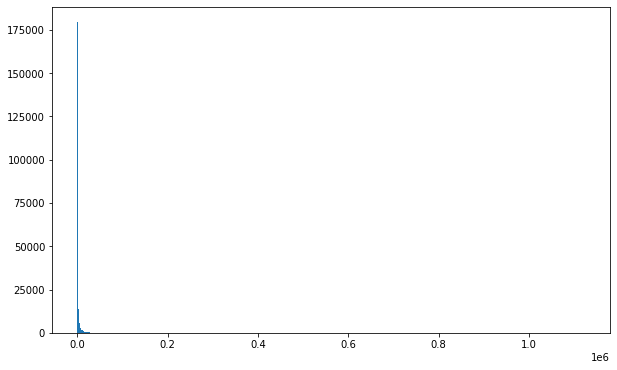

In [ ]:
plt.figure(figsize = (10, 6))
len_text = df['Text'].apply(lambda x: len(str(x).split())).values
plt.hist(len_text, bins=1000)
plt.show()

In [ ]:
len_text.shape

(257625,)

In [ ]:
len_text[len_text < 4096].shape

(225221,)

In [ ]:
len_text[len_text < 3072].shape

(215936,)

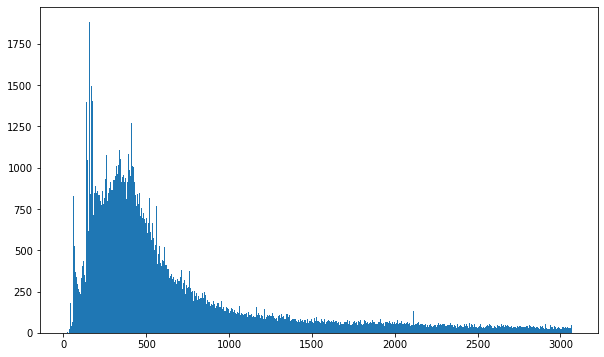

In [ ]:
plt.figure(figsize = (10, 6))
plt.hist(len_text[len_text < 3072], bins=1000)
plt.show()

In [ ]:
label_dicts = defaultdict(int)
for labels in df['labels']:
    for label in labels:
        label_dicts[label]+=1
labels = pd.Series(label_dicts).to_frame()
labels.rename(columns={0:'cnt'}, inplace = True)
labels['category'] = pd.cut(labels['cnt'], bins = [0, 1, 10, 50, 100, 500, 1000, 2500, 5000, 10000, 15000], labels = ['1label','10labels', '50labels', '100labels', '500labels', '1000labels', '2500labels', '5000labels', '10000labels', '15000labels',])
labels.sort_values(by='cnt')

,cnt,category
political philosophy,1,1label
Panama Canal,1,1label
Central Croatia,1,1label
Liberalism,1,1label
populism,1,1label
...,...,...
control of State aid,9231,10000labels
European Commission,9855,10000labels
State aid,11775,15000labels
merger control,12485,15000labels


In [ ]:
labels.groupby('category')['category'].count().to_frame()

,category
category,
1label,339
10labels,1313
50labels,1838
100labels,885
500labels,1582
1000labels,400
2500labels,245
5000labels,64
10000labels,24


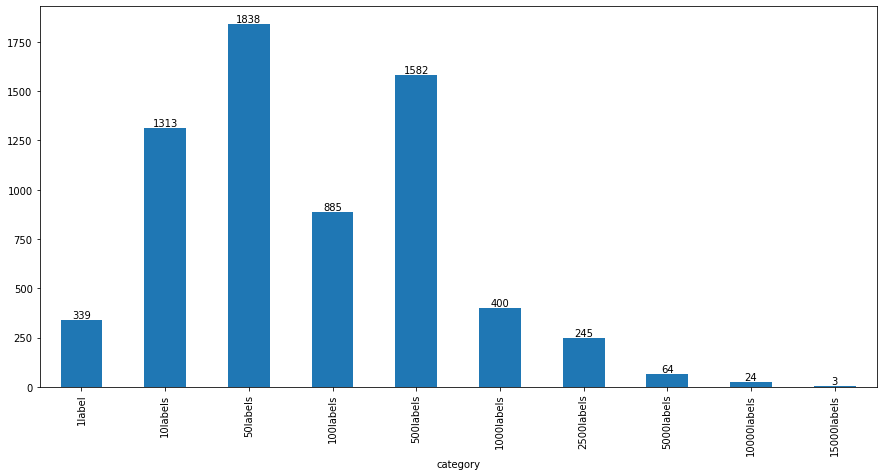

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
ax = labels.groupby('category')['category'].count().plot.bar()
ax.bar_label(ax.containers[0])
plt.show()

In [ ]:
filtered_labels = set(labels[(labels['category']== '15000labels') | 
                             (labels['category']== '10000labels') |
                             (labels['category']== '5000labels')].index)
len(filtered_labels)

91

In [ ]:
df['check_labels'] = df['labels'].apply(lambda x: any(label in filtered_labels for label in x))
print(np.unique(df['check_labels'], return_counts = True))
df = df[df['check_labels']]
df.head()

(array([False,  True]), array([ 11737, 245888]))


,CELEX,Text,labels,check_labels
0,21972A0722(03),21972A0722(03) Agreement between the European ...,"[Switzerland, trading operation, customs dutie...",True
1,21980D1231(03),21980D1231(03) Decision No 3/80 of the EEC-Ice...,"[Greece, tariff policy, agreement (EU), access...",True
2,21981A0710(02),21981A0710(02) Exchange of letters between the...,"[Hungary, trade agreement (EU), goatmeat, shee...",True
3,21986A1115(03),15.11.1986 EN Official Journal of the European...,"[trade agreement, Portugal, protocol to an agr...",True
4,21987A0720(02),20.7.1987 EN Official Journal of the European ...,"[protocol to an agreement, customs harmonisati...",True


In [ ]:
df['labels'] = df['labels'].apply(lambda x: [label for label in x if label in filtered_labels])
df.reset_index(drop=True, inplace = True)
df

,CELEX,Text,labels,check_labels
0,21972A0722(03),21972A0722(03) Agreement between the European ...,"[customs duties, trade agreement (EU), GATT]",True
1,21980D1231(03),21980D1231(03) Decision No 3/80 of the EEC-Ice...,"[Greece, agreement (EU), accession to the Euro...",True
2,21981A0710(02),21981A0710(02) Exchange of letters between the...,"[Hungary, trade agreement (EU)]",True
3,21986A1115(03),15.11.1986 EN Official Journal of the European...,"[trade agreement, Portugal, trade agreement (E...",True
4,21987A0720(02),20.7.1987 EN Official Journal of the European ...,[revision of an agreement],True
...,...,...,...,...
245883,E2019C1212(01),12.12.2019 EN Official Journal of the European...,"[Iceland, electrical energy, electricity suppl...",True
245884,E2019P0003,22.8.2019 EN Official Journal of the European ...,"[insurance company, equal treatment]",True
245885,E2021C0121(01),21.1.2021 EN Official Journal of the European ...,"[State aid, reimbursement of aid, interest, Ic...",True
245886,E2021C0520(02),20.5.2021 EN Official Journal of the European ...,[European Economic Area],True


In [ ]:
label_sets = set()
label_dicts = defaultdict(int)
for labels in df['labels']:
    for label in labels:
        label_sets.add(label)
        if label not in label_dicts:
         label_dicts[label] = len(label_sets)
label_list = list(label_sets)

In [ ]:
len(label_list)

512

In [ ]:
df['enc_labels'] = df['labels'].apply(lambda labels: [label_dicts[label] for label in labels])
df.head()

,CELEX,Text,labels,check_labels,enc_labels
0,21972A0722(03),21972A0722(03) Agreement between the European ...,"[customs duties, trade agreement (EU), GATT]",True,"[1, 2, 3]"
1,21980D1231(03),21980D1231(03) Decision No 3/80 of the EEC-Ice...,"[Greece, agreement (EU), accession to the Euro...",True,"[4, 5, 6, 7]"
2,21981A0710(02),21981A0710(02) Exchange of letters between the...,"[Hungary, trade agreement (EU)]",True,"[8, 2]"
3,21986A1115(03),15.11.1986 EN Official Journal of the European...,"[trade agreement, Portugal, trade agreement (E...",True,"[9, 10, 2, 6, 7]"
4,21987A0720(02),20.7.1987 EN Official Journal of the European ...,[revision of an agreement],True,[11]


In [ ]:
def new_feature(targets):
    ntarget = []
    for a in range(1, len(label_list)+1):
        ntarget.append(1 if a in targets else 0)
    return ntarget
print(new_feature(df['enc_labels'][3]))
print(len(new_feature(df['enc_labels'][3])))

[0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
df['ohe_labels'] = df['enc_labels'].apply(lambda x: new_feature(x))
df.head()

,CELEX,Text,labels,check_labels,enc_labels,ohe_labels
0,21972A0722(03),21972A0722(03) Agreement between the European ...,"[customs duties, trade agreement (EU), GATT]",True,"[1, 2, 3]","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,21980D1231(03),21980D1231(03) Decision No 3/80 of the EEC-Ice...,"[Greece, agreement (EU), accession to the Euro...",True,"[4, 5, 6, 7]","[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,21981A0710(02),21981A0710(02) Exchange of letters between the...,"[Hungary, trade agreement (EU)]",True,"[8, 2]","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,21986A1115(03),15.11.1986 EN Official Journal of the European...,"[trade agreement, Portugal, trade agreement (E...",True,"[9, 10, 2, 6, 7]","[0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, ..."
4,21987A0720(02),20.7.1987 EN Official Journal of the European ...,[revision of an agreement],True,[11],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."


In [ ]:
df = df[['CELEX', 'Text', 'ohe_labels']]
df.head()

,CELEX,Text,ohe_labels
0,21972A0722(03),21972A0722(03) Agreement between the European ...,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,21980D1231(03),21980D1231(03) Decision No 3/80 of the EEC-Ice...,"[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,21981A0710(02),21981A0710(02) Exchange of letters between the...,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,21986A1115(03),15.11.1986 EN Official Journal of the European...,"[0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, ..."
4,21987A0720(02),20.7.1987 EN Official Journal of the European ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."


In [ ]:
train_df, test_df = train_test_split(df, train_size = 0.8)

In [ ]:
train_size = 0.8
train_dataset=train_df.sample(frac=train_size,random_state=200)
test_dataset=train_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)
train_dataset

,CELEX,Text,ohe_labels
0,31984D0559,31984D0559 84/559/EEC: Council Decision of 22 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,32010D0700,23.11.2010 EN Official Journal of the European...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,52000PC0733,52000PC0733 Proposal for a Council Regulation ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,62013FB0108,10.11.2014 EN Official Journal of the European...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,52018IE4753,16.7.2019 EN Official Journal of the European ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
157363,52012DC0791,52012DC0791 COMMUNICATION FROM THE COMMISSION ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
157364,C2012/146/07,24.5.2012 EN Official Journal of the European ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
157365,62018CA0071,11.11.2019 EN Official Journal of the European...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
157366,32007R0405,14.4.2007 EN Official Journal of the European ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
test_dataset

,CELEX,Text,ohe_labels
0,C2010/352/03,23.12.2010 EN Official Journal of the European...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,92001E001598,92001E1598 WRITTEN QUESTION E-1598/01 by André...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,92000E003422,92000E3422 WRITTEN QUESTION E-3422/00 by Ioann...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,31993R3049,31993R3049 Commission Regulation (EC) No 3049/...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,91996E003099,91996E3099 WRITTEN QUESTION No. 3099/96 by Ani...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
39337,32000D0231,32000D0231 Council Decision of 20 March 2000 s...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
39338,91997E000699(01),91997E0699(01) WRITTEN QUESTION No. 699/97 by ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
39339,31989R3777,"31989R3777 Council Regulation (EEC, Euratom, E...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
39340,91999E000308,91999E0308 WRITTEN QUESTION No. 308/99 by Davi...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


In [ ]:
# instantiate a Longformer for multilabel classification class
class LongformerForMultiLabelSequenceClassification(LongformerPreTrainedModel):
    """
    We instantiate a class of LongFormer adapted for a multilabel classification task. 
    This instance takes the pooled output of the LongFormer based model and passes it through a classification head. We replace the traditional Cross Entropy loss with a BCE loss that generate probabilities for all the labels that we feed into the model.
    """

    def __init__(self, config):
        super(LongformerForMultiLabelSequenceClassification, self).__init__(config)
        self.num_labels = config.num_labels
        self.longformer = LongformerModel(config)
        self.classifier = LongformerClassificationHead(config)
        self.init_weights()
        
    def forward(self, input_ids=None, attention_mask=None, global_attention_mask=None, 
                token_type_ids=None, position_ids=None, inputs_embeds=None, 
                labels=None):
        
        # create global attention on sequence, and a global attention token on the `s` token
        # the equivalent of the CLS token on BERT models. This is taken care of by HuggingFace
        # on the LongformerForSequenceClassification class
        if global_attention_mask is None:
            global_attention_mask = torch.zeros_like(input_ids)
            global_attention_mask[:, 0] = 1
        
        # pass arguments to longformer model
        outputs = self.longformer(
            input_ids = input_ids,
            attention_mask = attention_mask,
            global_attention_mask = global_attention_mask,
            token_type_ids = token_type_ids,
            position_ids = position_ids)
        
        # if specified the model can return a dict where each key corresponds to the output of a
        # LongformerPooler output class. In this case we take the last hidden state of the sequence
        # which will have the shape (batch_size, sequence_length, hidden_size). 
        sequence_output = outputs['last_hidden_state']
        
        # pass the hidden states through the classifier to obtain thee logits
        logits = self.classifier(sequence_output)
        outputs = (logits,) + outputs[2:]
        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            labels = labels.float()
            loss = loss_fct(logits.view(-1, self.num_labels), 
                            labels.view(-1, self.num_labels))
            #outputs = (loss,) + outputs
            outputs = (loss,) + outputs
        
        
        return outputs

In [ ]:
# instantiate a class that will handle the data
class Data_Processing(object):
    def __init__(self, tokenizer, id_column, text_column, label_column):
        
        # define the text column from the dataframe
        self.text_column = text_column.tolist()
    
        # define the label column and transform it to list
        self.label_column = label_column
        
        # define the id column and transform it to list
        self.id_column = id_column.tolist()
        
    
    # iter method to get each element at the time and tokenize it using bert        
    def __getitem__(self, index):
        comment_text = str(self.text_column[index])
        comment_text = " ".join(comment_text.split())
        # encode the sequence and add padding
        inputs = tokenizer.encode_plus(comment_text,
                                       add_special_tokens = True,
                                       max_length= 4096,
                                       padding = 'max_length',
                                       return_attention_mask = True,
                                       truncation = True,
                                       return_tensors='pt')
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        
        labels_ = torch.tensor(self.label_column[index], dtype=torch.float)
        id_ = self.id_column[index]
        return {'input_ids':input_ids[0], 'attention_mask':attention_mask[0], 
                'labels':labels_, 'id_':id_}
  
    def __len__(self):
        return len(self.text_column) 

In [ ]:
batch_size = 32

In [ ]:
# create a class to process the training and test data
tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096', 
                                                    padding = 'max_length',
                                                    truncation=True, 
                                                    max_length = 4096)

In [ ]:
training_data = Data_Processing(tokenizer, 
                                train_dataset['CELEX'], 
                                train_dataset['Text'], 
                                train_dataset['ohe_labels'])

In [ ]:
test_data =  Data_Processing(tokenizer, 
                             test_dataset['CELEX'], 
                             test_dataset['Text'], 
                             test_dataset['ohe_labels'])

In [ ]:
# use the dataloaders class to load the data
dataloaders_dict = {'train': DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=32),
                    'val': DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=32)
                   }

In [ ]:
dataset_sizes = {'train':len(training_data),
                 'val':len(test_data)
                }

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = LongformerForMultiLabelSequenceClassification.from_pretrained('allenai/longformer-base-4096',
                                                  gradient_checkpointing=False,
                                                  attention_window = 512,
                                                  num_labels = len(label_list),
                                                  cache_dir=data_dir+'model_all_data/',
                                                  return_dict=True)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForMultiLabelSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing LongformerForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForMultiLabelSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.d

In [ ]:
def multi_label_metrics(predictions, labels):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = np.zeros(probs.shape)
    y_true = labels
    y_pred[np.where(probs >= 0.5)] = 1
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # define dictionary of metrics to return
    metrics = {
        'f1': f1_micro_average,
        'roc_auc': roc_auc,
        'accuracy': accuracy
    }
    return metrics

In [ ]:
# Use the aux EvalPrediction class to obtain prediction labels
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [ ]:
training_args = TrainingArguments(
    output_dir = data_dir + 'results_all',
    group_by_length=True,
    length_column_name='input_length',
    per_device_train_batch_size=2,
    gradient_accumulation_steps=64,
    evaluation_strategy="steps",
    num_train_epochs=4,
    fp16=True,
    save_steps=1000,
    save_strategy='steps', # we cannot set it to "no". Otherwise, the model cannot guess the best checkpoint.
    eval_steps=1000,
    logging_steps=1000,
    learning_rate=5e-5,
    warmup_steps=500,
    save_total_limit=3,
    report_to="none",
    load_best_model_at_end = True, # this will let the model save the best checkpoint
    run_name = 'longformer_multilabel_trainer_4096_2e5a'
)

In [ ]:
# instantiate the trainer class and check for available devices
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_data,
    eval_dataset=test_data,
    compute_metrics = compute_metrics,
    #data_collator = Data_Processing(),
)

Using amp half precision backend


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
trainer.train()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model=torch.nn.DataParallel(trainer)
# model.to(device)



cuda


/home/ruslan/anaconda3/envs/lformer/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 157368
  Num Epochs = 4
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 512
  Gradient Accumulation steps = 64
  Total optimization steps = 1228
The following columns in the training set don't have a corresponding argument in `LongformerForMultiLabelSequenceClassification.forward` and have been ignored: id_. If id_ are not expected by `LongformerForMultiLabelSequenceClassification.forward`,  you can safely ignore this message.
/home/ruslan/anaconda3/envs/lformer/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to g

Step,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1000,0.133000,0.034490,0.000000,0.500000,0.000000


***** Running Evaluation *****
  Num examples = 39342
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `LongformerForMultiLabelSequenceClassification.forward` and have been ignored: id_. If id_ are not expected by `LongformerForMultiLabelSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to results_all/checkpoint-1000
Configuration saved in results_all/checkpoint-1000/config.json
Model weights saved in results_all/checkpoint-1000/pytorch_model.bin
/home/ruslan/anaconda3/envs/lformer/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results_all/checkpoint-1000 (score: 0.0344899

TrainOutput(global_step=1228, training_loss=0.11469291980569447, metrics={'train_runtime': 85432.4317, 'train_samples_per_second': 7.368, 'train_steps_per_second': 0.014, 'total_flos': 1.668594446905639e+18, 'train_loss': 0.11469291980569447, 'epoch': 4.0})

In [ ]:
trainer.model.save_pretrained(data_dir+'trained_model_all_data/longformer_base_multilabel_4096_2e5')
tokenizer.save_pretrained(data_dir+'tokenizer_all_data/longformer_base_multilabel_4096_2e5')

Configuration saved in trained_model_all_data/longformer_base_multilabel_4096_2e5/config.json
Model weights saved in trained_model_all_data/longformer_base_multilabel_4096_2e5/pytorch_model.bin
tokenizer config file saved in tokenizer_all_data/longformer_base_multilabel_4096_2e5/tokenizer_config.json
Special tokens file saved in tokenizer_all_data/longformer_base_multilabel_4096_2e5/special_tokens_map.json


('tokenizer_all_data/longformer_base_multilabel_4096_2e5/tokenizer_config.json',
 'tokenizer_all_data/longformer_base_multilabel_4096_2e5/special_tokens_map.json',
 'tokenizer_all_data/longformer_base_multilabel_4096_2e5/vocab.json',
 'tokenizer_all_data/longformer_base_multilabel_4096_2e5/merges.txt',
 'tokenizer_all_data/longformer_base_multilabel_4096_2e5/added_tokens.json',
 'tokenizer_all_data/longformer_base_multilabel_4096_2e5/tokenizer.json')

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 39342
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `LongformerForMultiLabelSequenceClassification.forward` and have been ignored: id_. If id_ are not expected by `LongformerForMultiLabelSequenceClassification.forward`,  you can safely ignore this message.


{'eval_loss': 0.03448992967605591,
 'eval_f1': 0.0,
 'eval_roc_auc': 0.5,
 'eval_accuracy': 0.0,
 'eval_runtime': 1516.0156,
 'eval_samples_per_second': 25.951,
 'eval_steps_per_second': 0.811,
 'epoch': 4.0}

In [ ]:
# instantiate a class that will handle the data
class Data_Processing_test():
    def __init__(self, tokenizer, id_column, text_column):
        
        # define the text column from the dataframe
        self.text_column = text_column.tolist()
                    
        # define the id column and transform it to list
        self.id_column = id_column.tolist()
            
# iter method to get each element at the time and tokenize it using bert        
    def __getitem__(self, index):
        comment_text = str(self.text_column[index])
        comment_text = " ".join(comment_text.split())
        
        inputs = tokenizer.encode_plus(comment_text,
                                       add_special_tokens = True,
                                       max_length= 2048,
                                       padding = 'max_length',
                                       return_attention_mask = True,
                                       truncation = True,
                                       return_tensors='pt')
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        id_ = self.id_column[index]
        return {'input_ids':input_ids[0], 'attention_mask':attention_mask[0], 
                'id_':id_}
  
    def __len__(self):
        return len(self.text_column) 

In [ ]:
batch_size = 32
# create a class to process the traininga and test data

test_data_pred =  Data_Processing_test(tokenizer,
                                       test_df['CELEX'], 
                                       test_df['Text'])

# use the dataloaders class to load the data
dataloaders_dict = {'test': DataLoader(test_data_pred,
                                                 batch_size=batch_size, shuffle=True, num_workers=32)}

In [ ]:
def prediction():
    prediction_data_frame_list = []
    with torch.no_grad():
        trainer.model.eval()
        for i, batch in enumerate(dataloaders_dict['test']):
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            # feed the sequences to the model, specifying the attention mask
            outputs = model(inputs, attention_mask=attention_mask)
            # feed the logits returned by the model to the softmax to classify the function
            sigmoid = torch.nn.Sigmoid()
            probs = sigmoid(torch.Tensor(outputs[0].detach().cpu().data.numpy()))
            #probs.
            probs = np.array(probs)
            #print(np.array([[i] for i in probs]))
            y_pred = np.zeros(probs.shape)
            y_pred = probs
            temp_data = pd.DataFrame(zip(batch['id_'], probs), columns = ['id', 'target'
                                                                         ])
            #print(temp_data)
            prediction_data_frame_list.append(temp_data)                

    prediction_df = pd.concat(prediction_data_frame_list)
    prediction_df[label_list] = pd.DataFrame(prediction_df.target.tolist(),
                                                                                index= prediction_df.index)
    prediction_df = prediction_df.drop(columns = 'target')
    return prediction_df

predictions = prediction()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/ruslan/anaconda3/envs/lformer/lib/python3.7/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


In [ ]:
predictions

,id,quantitative restriction,activity report,European Central Bank,information society,advisory committee (EU),transport safety,export refund,dumping,product designation,...,plant health control,European citizenship,chemical industry,dissemination of information,reimbursement of aid,protection of privacy,innovation,European Commission,labour market,intra-EU trade
0,31987R1652,0.005633,0.008950,0.004803,0.015757,0.022007,0.012757,0.006956,0.006736,0.004651,...,0.006909,0.011892,0.005243,0.005495,0.007223,0.005926,0.006341,0.004999,0.005415,0.005386
1,52013PC0347,0.005633,0.008947,0.004803,0.015755,0.022009,0.012758,0.006955,0.006734,0.004650,...,0.006909,0.011894,0.005241,0.005493,0.007223,0.005926,0.006340,0.004999,0.005416,0.005387
2,C2005/117/01,0.005633,0.008951,0.004802,0.015760,0.022008,0.012762,0.006958,0.006738,0.004651,...,0.006910,0.011900,0.005243,0.005495,0.007225,0.005926,0.006341,0.005001,0.005417,0.005385
3,92002E001509,0.005633,0.008950,0.004803,0.015754,0.022007,0.012758,0.006954,0.006736,0.004651,...,0.006909,0.011893,0.005243,0.005495,0.007225,0.005926,0.006342,0.004999,0.005416,0.005385
4,52020M9895(01),0.005634,0.008950,0.004801,0.015754,0.022006,0.012756,0.006955,0.006737,0.004652,...,0.006909,0.011895,0.005242,0.005495,0.007224,0.005927,0.006342,0.004998,0.005416,0.005387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,32018D1303,0.005632,0.008949,0.004803,0.015754,0.022005,0.012756,0.006955,0.006735,0.004650,...,0.006910,0.011892,0.005241,0.005493,0.007222,0.005927,0.006340,0.004998,0.005415,0.005386
22,32001D1228(01),0.005632,0.008949,0.004803,0.015757,0.022012,0.012757,0.006956,0.006735,0.004651,...,0.006909,0.011892,0.005242,0.005494,0.007223,0.005926,0.006341,0.005000,0.005416,0.005386
23,52009IP0177,0.005633,0.008951,0.004803,0.015755,0.022011,0.012758,0.006955,0.006735,0.004651,...,0.006910,0.011890,0.005242,0.005494,0.007223,0.005927,0.006342,0.004999,0.005416,0.005386
24,32018R0660,0.005633,0.008951,0.004803,0.015755,0.022005,0.012758,0.006955,0.006735,0.004651,...,0.006909,0.011894,0.005242,0.005494,0.007222,0.005928,0.006341,0.004999,0.005416,0.005386


In [ ]:
rm_id = np.random.randint(len(test_df))
idx =  predictions.iloc[rm_id, 0]
ohe_labels = test_df[test_df['CELEX'] == idx]['ohe_labels'].sum()
for i in range(len(ohe_labels)):
    if ohe_labels[i]==1:
        print(label_list[i])

budgetary discharge


In [ ]:
predictions

,id,quantitative restriction,activity report,European Central Bank,information society,advisory committee (EU),transport safety,export refund,dumping,product designation,...,plant health control,European citizenship,chemical industry,dissemination of information,reimbursement of aid,protection of privacy,innovation,European Commission,labour market,intra-EU trade
0,31987R1652,0.005633,0.008950,0.004803,0.015757,0.022007,0.012757,0.006956,0.006736,0.004651,...,0.006909,0.011892,0.005243,0.005495,0.007223,0.005926,0.006341,0.004999,0.005415,0.005386
1,52013PC0347,0.005633,0.008947,0.004803,0.015755,0.022009,0.012758,0.006955,0.006734,0.004650,...,0.006909,0.011894,0.005241,0.005493,0.007223,0.005926,0.006340,0.004999,0.005416,0.005387
2,C2005/117/01,0.005633,0.008951,0.004802,0.015760,0.022008,0.012762,0.006958,0.006738,0.004651,...,0.006910,0.011900,0.005243,0.005495,0.007225,0.005926,0.006341,0.005001,0.005417,0.005385
3,92002E001509,0.005633,0.008950,0.004803,0.015754,0.022007,0.012758,0.006954,0.006736,0.004651,...,0.006909,0.011893,0.005243,0.005495,0.007225,0.005926,0.006342,0.004999,0.005416,0.005385
4,52020M9895(01),0.005634,0.008950,0.004801,0.015754,0.022006,0.012756,0.006955,0.006737,0.004652,...,0.006909,0.011895,0.005242,0.005495,0.007224,0.005927,0.006342,0.004998,0.005416,0.005387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,32018D1303,0.005632,0.008949,0.004803,0.015754,0.022005,0.012756,0.006955,0.006735,0.004650,...,0.006910,0.011892,0.005241,0.005493,0.007222,0.005927,0.006340,0.004998,0.005415,0.005386
22,32001D1228(01),0.005632,0.008949,0.004803,0.015757,0.022012,0.012757,0.006956,0.006735,0.004651,...,0.006909,0.011892,0.005242,0.005494,0.007223,0.005926,0.006341,0.005000,0.005416,0.005386
23,52009IP0177,0.005633,0.008951,0.004803,0.015755,0.022011,0.012758,0.006955,0.006735,0.004651,...,0.006910,0.011890,0.005242,0.005494,0.007223,0.005927,0.006342,0.004999,0.005416,0.005386
24,32018R0660,0.005633,0.008951,0.004803,0.015755,0.022005,0.012758,0.006955,0.006735,0.004651,...,0.006909,0.011894,0.005242,0.005494,0.007222,0.005928,0.006341,0.004999,0.005416,0.005386


In [ ]:
predictions.to_csv(data_dir+'predictions.csv', index = False)

In [ ]:
predictions.set_index('id', inplace = True)
predictions.T

id,31987R1652,52013PC0347,C2005/117/01,92002E001509,52020M9895(01),52007XC1109(04),52005XC0930(03),92004E000955,31993D0508,32001R2573R(01),...,32005R0015,31996R2501,C2011/094/08,62014FA0028,32003D0828,32018D1303,32001D1228(01),52009IP0177,32018R0660,32020R0693
quantitative restriction,0.005633,0.005633,0.005633,0.005633,0.005634,0.005634,0.005634,0.005632,0.005633,0.005634,...,0.005633,0.005633,0.005633,0.005632,0.005634,0.005632,0.005632,0.005633,0.005633,0.005633
activity report,0.008950,0.008947,0.008951,0.008950,0.008950,0.008950,0.008949,0.008950,0.008950,0.008949,...,0.008950,0.008951,0.008951,0.008949,0.008952,0.008949,0.008949,0.008951,0.008951,0.008950
European Central Bank,0.004803,0.004803,0.004802,0.004803,0.004801,0.004805,0.004801,0.004802,0.004803,0.004801,...,0.004803,0.004804,0.004802,0.004803,0.004802,0.004803,0.004803,0.004803,0.004803,0.004803
information society,0.015757,0.015755,0.015760,0.015754,0.015754,0.015753,0.015756,0.015754,0.015756,0.015761,...,0.015757,0.015754,0.015761,0.015757,0.015756,0.015754,0.015757,0.015755,0.015755,0.015757
advisory committee (EU),0.022007,0.022009,0.022008,0.022007,0.022006,0.022014,0.022011,0.022011,0.022011,0.022007,...,0.022009,0.022011,0.022010,0.022009,0.022010,0.022005,0.022012,0.022011,0.022005,0.022008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
protection of privacy,0.005926,0.005926,0.005926,0.005926,0.005927,0.005927,0.005925,0.005928,0.005928,0.005927,...,0.005926,0.005928,0.005926,0.005926,0.005927,0.005927,0.005926,0.005927,0.005928,0.005926
innovation,0.006341,0.006340,0.006341,0.006342,0.006342,0.006341,0.006341,0.006342,0.006342,0.006341,...,0.006340,0.006340,0.006340,0.006341,0.006341,0.006340,0.006341,0.006342,0.006341,0.006341
European Commission,0.004999,0.004999,0.005001,0.004999,0.004998,0.004999,0.004998,0.005000,0.005000,0.005002,...,0.004998,0.004998,0.005001,0.005000,0.004998,0.004998,0.005000,0.004999,0.004999,0.004999
labour market,0.005415,0.005416,0.005417,0.005416,0.005416,0.005415,0.005416,0.005417,0.005416,0.005415,...,0.005415,0.005414,0.005417,0.005416,0.005415,0.005415,0.005416,0.005416,0.005416,0.005416


In [ ]:
pred_transform = predictions.T.copy()
top_5 = pd.DataFrame(index = predictions.index, columns = ['Top_1', 'Top_2', 'Top_3', 'Top_4', 'Top_5', 'labels'])
for col in pred_transform.columns:
    ohe_labels = test_df[test_df['CELEX'] == col]['ohe_labels'].sum()
    labels = []
    for i in range(len(ohe_labels)):
        if ohe_labels[i]==1:
            labels.append(label_list[i])
    
    top_5.loc[col] = list(predictions.T[col].nlargest(5).items()) + [tuple(labels)]
    
top_5

/home/ruslan/anaconda3/envs/lformer/lib/python3.7/site-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


,Top_1,Top_2,Top_3,Top_4,Top_5,labels
id,,,,,,
31987R1652,"(live animal, 0.048958998173475266)","(budgetary discharge, 0.046346310526132584)","(commercial vehicle, 0.039582934230566025)","(road transport, 0.033837612718343735)","(anti-dumping measure, 0.033704470843076706)","(free movement of goods, public finance, broad..."
52013PC0347,"(live animal, 0.04896866902709007)","(budgetary discharge, 0.04633862525224686)","(commercial vehicle, 0.03958342224359512)","(road transport, 0.03384438529610634)","(anti-dumping measure, 0.03370284661650658)","(market access, Italy, application of EU law)"
C2005/117/01,"(live animal, 0.048955660313367844)","(budgetary discharge, 0.04635239765048027)","(commercial vehicle, 0.039568644016981125)","(road transport, 0.03384941443800926)","(anti-dumping measure, 0.03371657803654671)","(fresh meat,)"
92002E001509,"(live animal, 0.04895934462547302)","(budgetary discharge, 0.04634130373597145)","(commercial vehicle, 0.03956400230526924)","(road transport, 0.03383265435695648)","(anti-dumping measure, 0.03370162844657898)","(Lithuania, sea fishing)"
52020M9895(01),"(live animal, 0.04896759241819382)","(budgetary discharge, 0.04634498432278633)","(commercial vehicle, 0.039578262716531754)","(road transport, 0.033837977796792984)","(anti-dumping measure, 0.03370993956923485)","(live animal, Romania)"
...,...,...,...,...,...,...
32018D1303,"(live animal, 0.04896784946322441)","(budgetary discharge, 0.04634002596139908)","(commercial vehicle, 0.039579425007104874)","(road transport, 0.033843569457530975)","(anti-dumping measure, 0.03370557352900505)","(social security, transport regulations, Israe..."
32001D1228(01),"(live animal, 0.04896475002169609)","(budgetary discharge, 0.04634016379714012)","(commercial vehicle, 0.039587054401636124)","(road transport, 0.033840347081422806)","(anti-dumping measure, 0.03370744362473488)","(European citizenship,)"
52009IP0177,"(live animal, 0.04896460846066475)","(budgetary discharge, 0.0463484488427639)","(commercial vehicle, 0.03958335891366005)","(road transport, 0.03382853418588638)","(anti-dumping measure, 0.03370543196797371)","(emergency aid, European Court of Auditors, ve..."


In [ ]:
top_5.to_csv('top_5.csv')

In [ ]:
top_5.sample(10)

,Top_1,Top_2,Top_3,Top_4,Top_5,labels
id,,,,,,
62009FN0071,"(live animal, 0.048971399664878845)","(budgetary discharge, 0.04635516181588173)","(commercial vehicle, 0.03958048298954964)","(road transport, 0.03383690491318703)","(anti-dumping measure, 0.03370371460914612)","(quality control of agricultural products, swi..."
32021R0344,"(live animal, 0.04896651580929756)","(budgetary discharge, 0.046333033591508865)","(commercial vehicle, 0.03957785665988922)","(road transport, 0.03384005278348923)","(anti-dumping measure, 0.033705100417137146)","(economic convergence,)"
32005R0307,"(live animal, 0.048958998173475266)","(budgetary discharge, 0.04634581506252289)","(commercial vehicle, 0.039581023156642914)","(road transport, 0.033847372978925705)","(anti-dumping measure, 0.033701226115226746)","(European civil service, provision of services..."
32010R0868,"(live animal, 0.04895419254899025)","(budgetary discharge, 0.04634355008602142)","(commercial vehicle, 0.03958413749933243)","(road transport, 0.03384580463171005)","(anti-dumping measure, 0.033709097653627396)","(animal welfare,)"
31974H0256,"(live animal, 0.048959288746118546)","(budgetary discharge, 0.04633842781186104)","(commercial vehicle, 0.03957924246788025)","(road transport, 0.03384232893586159)","(anti-dumping measure, 0.033705439418554306)","(surveillance concerning imports, natural gas,..."
52014XC0703(02),"(live animal, 0.048961374908685684)","(budgetary discharge, 0.04634329676628113)","(commercial vehicle, 0.039575863629579544)","(road transport, 0.03383904695510864)","(anti-dumping measure, 0.03370245173573494)","(financial aid, Cyprus, Yugoslavia, national l..."
51997IP0187,"(live animal, 0.04895895719528198)","(budgetary discharge, 0.0463368222117424)","(commercial vehicle, 0.03957879915833473)","(road transport, 0.03384207934141159)","(anti-dumping measure, 0.03370072692632675)","(European Community, holding company, EAGGF Gu..."
91996E002176,"(live animal, 0.04896315187215805)","(budgetary discharge, 0.04632804915308952)","(commercial vehicle, 0.039582207798957825)","(road transport, 0.03383723646402359)","(anti-dumping measure, 0.0337117537856102)","(commercial vehicle,)"
52007XX1201(02),"(live animal, 0.048980530351400375)","(budgetary discharge, 0.04635154828429222)","(commercial vehicle, 0.03958132117986679)","(road transport, 0.033847060054540634)","(anti-dumping measure, 0.033713843673467636)","(protected area, investment aid, live animal, ..."


# Load Pretrain model

In [ ]:
from transformers import LongformerTokenizer, EncoderDecoderModel, LongformerModel

In [ ]:
data_dir = ''
model = LongformerModel.from_pretrained(data_dir+'trained_model_all_data/longformer_base_multilabel_3072_2e5')

Some weights of the model checkpoint at trained_model_all_data/longformer_base_multilabel_3072_2e5 were not used when initializing LongformerModel: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenizer = LongformerTokenizer.from_pretrained(data_dir+'tokenizer_all_data/longformer_base_multilabel_3072_2e5')